<br><br><center><h1 style="font-size:2em;color:#2467C0">Project: Sparkify</h1></center>
<br>
<table>
<col width="550">
<col width="450">
<tr>
<td><img src="ApacheSpark.png" align="middle" style="width:400px;height:200px;"/></td>
<td>
This Notebook contains the capstone project of the Data Science Nanodegree offered by Udacity. The goal of the project is to manipulate a large and realistic dataset using Spark and build a machine learning classifier for predicting churn for the imaginary music streaming application Sparkify. For all the analysis and model training a Spark cluster was deployed on the cloud using IBM Watson Studio. This submission corresponds to the whole project solution from data gathering and cleaning, through exploratory analysis up to training a Machine Learning Classifier. All the required tasks to accomplish the project goals, code, analysis and conclusions are part of this final report. 
<br>
<br>
<br>
A medium size dataset provided by Udacity was uploaded to the IBM Cloud platform and used for the analysis.
<br>
<br>
<h1 style="font-size:1em;color:#2467C0">This Notebook was created by: Gustavo Cedeño</h1>

</tr>
</table>

## Table of Contents
<ul>
    
<li><a href='#intro'>Introduction</a></li>
    <ul>
      <li><a href='#definition'>Problem or Idea Definition</a></li>
</ul>
    
    
<li><a href='#intro'>Project Description</a></li>
    <ul>
      <li><a href='#datasource'>DataSource</a></li>
      <li><a href='#requirements'> Required Libraries </a></li>
</ul>

<li><a href='#wrangling'>Data Wrangling</a></li>
 

<li><a href='#EDA'>Exploratory Data Analysis</a></li>
  
<li><a href='#method'>Methodology: Model and Predictive Data Analysis</a></li>
    <ul>
      <li><a href='#model'>Model Selection</a></li>
      <li><a href='#implementation'>Model Implementation</a></li>
      <li><a href='#evaluation'>Evaluating Model Performance</a></li>
  </ul>
   
<li><a href='#results'>Results</a></li>
    <ul>
      <li><a href='#discussion'>Discussion</a></li>
      <li><a href='#conclusion'>Conclusion</a></li>
    
</ul>
<li><a href='#reference'>References</a></li> 

<a id='intro'></a>
# Introduction

>Sparkify is an imaginary music streaming application. The idea for this project is to manipulate a dataset containing user's information using Spark and to engineer relevant features and learn how to use Spark MLlib to build machine learning models for predicting churn.  

>
<a id='definition'></a>
## Problem or Idea Definition

> Predicting churn rates is a challenging and common problem that data scientists and analysts regularly encounter in any customer-facing business. Additionally, the ability to efficiently manipulate large datasets with Spark is one of the highest-demand skills in the field of data.

> This project allows to develop two essential data analytics skills, namely:
* Load large datasets into Spark and manipulate them using Spark SQL and Spark Dataframes
* Use the machine learning APIs within Spark ML to build and tune models

<a id='projectdetails'></a>
# Project Details
>For this project, I decided to deploy a Spark cluster on the cloud using IBM Watson Studio. A medium sized dataset provided by Udacity was used for the analysis. 

>Main tasks in this project are as follows:
>1. Gathering data
>2. Assessing and cleaning data
>3. Exploratory Data Analysis
>4. Engineering features.
>5. Trainning and Tuning ML Classifiers.
>6. Results analysis.

<a id='datasource'></a>
## Data Source
>The dataset "medium_sparkify_event_data.json" provided by Udacity was used for the analysis. 

## Loading the data on Watson Studio
> To run the analysis on Watson Studio, first we need to upload the data to IBM Cloud, then select "insert to code", follow by "Insert Spark DataFrame" to generate a code that reads in the data into your Watson Studio notebook. Once done that, you're all set to start building your model on IBM Cloud!    

In [1]:

import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-076a86f1-5ec1-4fba-9278-5d077471f129',
    'iam_service_endpoint': 'https://iam.ng.bluemix.net/oidc/token',
    'api_key': '3FnNIMzjrE3g_nuiJPdEXilu4foLRsY8UCwZ18dhqbL_'
}

configuration_name = 'os_1b1bbe777b774fb798ec063f4e838f0b_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

# df_data_1 = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-jzqnqepywac0wd'))
# df_data_1.take(5)
df = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-jzqnqepywac0wd'))
df.show(5)

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20191012135724-0000
KERNEL_ID = 962662db-e145-473a-81b0-60d2301133e3
+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------------------+------+-------------+--------------------+------+
|           artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|              song|status|           ts|           userAgent|userId|
+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------------------+------+-------------+--------------------+------+
|    Martin Orford|Logged In|   Joseph|     M|           20| Morales|597.55057| free|  Corpus Christi, TX|   PUT|NextSong|1532063507000|      292|     Grand Designs|   200|1538352011000|"Mozilla/5.0 

<a id='requirements'></a>
## System and Libraries 

In [2]:
# import libraries
from pyspark.sql.functions import avg, substring, col, when, desc, min, max, sum, \
split, udf, count, countDistinct, rand, struct, isnan, isnull, from_unixtime, dayofmonth, month, datediff, to_date, lit, current_date
from pyspark.sql.types import IntegerType, ArrayType, FloatType, DoubleType, Row, DateType
from pyspark.ml.linalg import DenseVector, SparseVector

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.sql.functions import sum as Fsum
from pyspark.sql import Window
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime
import pickle

<a id='wrangling'></a>
# Data Wrangling
>>Data wrangling, which consists of the following tasks:
>1. Assessing data
>2. Cleaning data
>3. Transforming data

In [3]:
# Let's take a look at the dataset schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



Schema information

* artist: Artist name (e.g. 'Showaddywaddy')
* auth: User authentication status (e.g. 'Logged In')
* firstName: User first name (e.g. 'Kenneth')
* gender: Gender (e.g. F or M)
* itemInSession: Item count in a session (e.g. 112)
* lastName: User last name (e.g. 'Matthews')
* length: Length of song (e.g. 223.60771)
* level: User plan (e.g. paid)
* location: User's location (e.g. 'Charlotte-Concord-Gastonia, NC-SC')
* method: HTTP method (e.g. PUT)
* page: Page name (e.g. NextSong)
* registration: Registration timestamp (unix timestamp) (e.g. 1538173362000)
* sessionId: Session ID (e.g. 29)
* song: Song (e.g. 'Christmas Tears Will Fall')
* status: HTTP status (e.g. 200)
* ts: Event timestamp(unix timestamp) (e.g. 1538352676000)
* userAgent: User's browswer agent (e.g. '"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"') 
* userId: User ID (e.g. '1046')

In [4]:
# Converting to pandas dataframe to explore features
dfp = df.toPandas()
dfp.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martin Orford,Logged In,Joseph,M,20,Morales,597.55057,free,"Corpus Christi, TX",PUT,NextSong,1.532064e+12,292,Grand Designs,200,1538352011000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",293
1,John Brown's Body,Logged In,Sawyer,M,74,Larson,380.21179,free,"Houston-The Woodlands-Sugar Land, TX",PUT,NextSong,1.538070e+12,97,Bulls,200,1538352025000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",98
2,Afroman,Logged In,Maverick,M,184,Santiago,202.37016,paid,"Orlando-Kissimmee-Sanford, FL",PUT,NextSong,1.535953e+12,178,Because I Got High,200,1538352118000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",179
3,None,Logged In,Maverick,M,185,Santiago,NaN,paid,"Orlando-Kissimmee-Sanford, FL",PUT,Logout,1.535953e+12,178,None,307,1538352119000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",179
4,Lily Allen,Logged In,Gianna,F,22,Campos,194.53342,paid,"Mobile, AL",PUT,NextSong,1.535931e+12,245,Smile (Radio Edit),200,1538352124000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,246


In [5]:
# Checking general dataset details
dfp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543705 entries, 0 to 543704
Data columns (total 18 columns):
artist           432877 non-null object
auth             543705 non-null object
firstName        528005 non-null object
gender           528005 non-null object
itemInSession    543705 non-null int64
lastName         528005 non-null object
length           432877 non-null float64
level            543705 non-null object
location         528005 non-null object
method           543705 non-null object
page             543705 non-null object
registration     528005 non-null float64
sessionId        543705 non-null int64
song             432877 non-null object
status           543705 non-null int64
ts               543705 non-null int64
userAgent        528005 non-null object
userId           543705 non-null object
dtypes: float64(2), int64(4), object(12)
memory usage: 74.7+ MB


In [6]:
# Creating a view, to use SQL syntax 
df.createOrReplaceTempView('logs')

In [7]:
# Finding potential null values in critical columns
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|  song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+
|110828|   0|    15700| 15700|            0|   15700|110828|    0|   15700|     0|   0|       15700|        0|110828|     0|  0|    15700|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+



In [8]:
# Exploring missing values in firstName column
df.where(col('firstName').isNull()).show(10)

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          186|    null|  null| paid|    null|   GET| Home|        null|      178|null|   200|1538352148000|     null|      |
|  null|Logged Out|     null|  null|          187|    null|  null| paid|    null|   GET| Home|        null|      178|null|   200|1538352151000|     null|      |
|  null|Logged Out|     null|  null|          188|    null|  null| paid|    null|   GET| Home|        null|      178|null|   200|1538352168000|     null|      |
|  null|Logged Out|     null|  nul

In [9]:
# Exploring missing values in the artist column
df.where(col('artist').isNull()).show(10)

+------+----------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|            location|method|           page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|  null| Logged In| Maverick|     M|          185|Santiago|  null| paid|Orlando-Kissimmee...|   PUT|         Logout|1535953455000|      178|null|   307|1538352119000|"Mozilla/5.0 (Mac...|   179|
|  null|Logged Out|     null|  null|          186|    null|  null| paid|                null|   GET|           Home|         null|      178|null|   200|1538352148000|                null|      |
|  null|Logged Out|     n

In [10]:
# Filtering logged out users
df = df.where(col('auth') != 'Logged Out')

It looks like there are no missing values in the userId or sessionId columns. Checking at missing values in the firstName columns shows that logged out users have empty (but not null) user ID's.These users are excluded from our analysis. Missing values in the artist column correspond to logs for non-music related actions ("Add to Playlist", "Roll Advert", etc). As long as these users are logged in, we want to keep this activity for they could be relevant features for predicting behavior for classification.

<a id='EDA'></a>
# Exploratory Data Analysis
> During this section, we further explore the dataset and try to engineer features for model building. 

In [11]:
# Let's remind us the dataset's structure
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [12]:
# Visualize the first few rows
df.show(n=5)

+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------------------+------+-------------+--------------------+------+
|           artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|              song|status|           ts|           userAgent|userId|
+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------------------+------+-------------+--------------------+------+
|    Martin Orford|Logged In|   Joseph|     M|           20| Morales|597.55057| free|  Corpus Christi, TX|   PUT|NextSong|1532063507000|      292|     Grand Designs|   200|1538352011000|"Mozilla/5.0 (Mac...|   293|
|John Brown's Body|Logged In|   Sawyer|     M|           74|  Larson|380.21179| free|Houston-The Woodl...|   PUT|NextSong|1538069638000|    

In [13]:
# Visualize all the events and their associated counts
df.groupBy('Page').count().show()

+--------------------+------+
|                Page| count|
+--------------------+------+
|              Cancel|    99|
|    Submit Downgrade|   117|
|         Thumbs Down|  4911|
|                Home| 19130|
|           Downgrade|  3811|
|         Roll Advert|  7773|
|              Logout|  5990|
|       Save Settings|   585|
|Cancellation Conf...|    99|
|               About|  1048|
| Submit Registration|     4|
|            Settings|  2964|
|            Register|    11|
|     Add to Playlist| 12349|
|          Add Friend|  8087|
|            NextSong|432877|
|           Thumbs Up| 23826|
|                Help|  2658|
|             Upgrade|   968|
|               Error|   505|
+--------------------+------+
only showing top 20 rows



In [14]:
# We see how many unique users are present in this dataset
spark.sql('SELECT COUNT(DISTINCT userId) AS nb_users FROM logs').show()

+--------+
|nb_users|
+--------+
|     449|
+--------+



<a id='method'></a>
# Methodology
> Let's recall that the main goal is to better predict  churn, for that purpose it is needed to first define or create a feature to be used for classification. We then create a dataframe containing our new engineered feature, further explore the data, select the features we are going to use for making predictions, create a final dataset ready to be used by a machine learning classifier, train at least three different classifiers without parameters tuning and then select and optimize the parameters of at least one (or two if possible!) model.    

### Defining Churn
> After conducting some preliminary analysis, let's create a column `Churn` to be used as the label for training the machine learning classifier. It makes sense to use the `Cancellation Confirmation` events as a flag of churn, which happen for both paid and free users. 

#### According to our previously agreed definition: Churn is a label for users who cancelled
Let's recall all the `page` events in the dataset:

- About
- Add Friend
- Add to Playlist
- Cancel
- Cancellation Confirmation: **Event used as a flag of churn**
- Downgrade
- Error
- Help 
- Home
- Login 
- Logout
- NextSong 
- Register 
- Roll Advert
- Save Settings 
- Settings
- Submit Downgrade
- Submit Registration
- Submit Upgrade
- Thumbs Down
- Thumbs Up
- Upgrade

In [15]:
# Let's create a dataset with all user ID's and a label which specifies whether that individual churned or not

# Dataset with users who churned
churn = spark.sql('SELECT DISTINCT userId, 1 as churn FROM logs WHERE Page = "Cancellation Confirmation"')

# Then the other users
no_churn = spark.sql('SELECT DISTINCT userId, 0 as churn FROM logs \
                      WHERE userId NOT IN (SELECT DISTINCT userId FROM logs WHERE Page = "Cancellation Confirmation")')

# Create a dataframe from the union of the two, shuffling the rows
churn_df = churn.union(no_churn)
churn_df.createOrReplaceTempView('churn')
churn_df = spark.sql('SELECT * FROM churn ORDER BY RAND()')
churn_df.createOrReplaceTempView('churn')

# Checking that we have the right number of users
churn_df.count()

449

In [16]:
#Visualizing the distribution of users between churn or not
churn_pd_df = churn_df.toPandas()
churn_pd_df.groupby('churn', as_index=False).count()

,churn,userId
0,0,350
1,1,99


### Let's recap what we've done so far
>We first define churn at the user ID level by setting the cancellation confirmation event as the flag for churn, we then proceed by finding cancellation confirmation events and then creating an indicator that a user will churn. We can now select the relevant features that helps us analysing the user's behavior prior to churning and then build a predictive model, trained to recognize situations that indicate a risk of churning in the future.

>In order to proceed building a model, we first need to engineering some features, make data transformations and finally create a dataset ready to be used by a machine learning classifier. 

# Feature Engineering
>Now that we have defined churn, we can engineer features by studying differences between the group of users who churned and those who did not.

In [17]:
# Join the churn dataset to the full dataset adding a churn column
joined_df = df.join(churn_df, on='userId')

# Now we can further explore the data creating aggregations grouping by churn
joined_df.groupBy(['churn', 'level']).count().show(5)

+-----+-----+------+
|churn|level| count|
+-----+-----+------+
|    0| free| 82561|
|    0| paid|341892|
|    1| paid| 76152|
|    1| free| 27494|
+-----+-----+------+



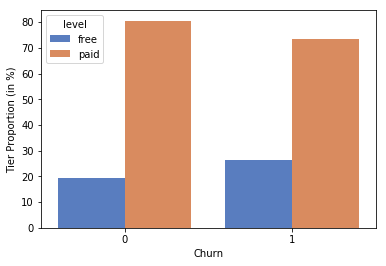

In [18]:
# Visualizing churn proportions by account level
level_df = joined_df.groupBy(['churn', 'level']).count().toPandas()
churn_sum = level_df.groupby('churn', as_index=False).sum()
level_df['proportion'] = (level_df.join(churn_sum, on = 'churn', lsuffix='_1')['count_1']/level_df.join(churn_sum, on = 'churn', lsuffix='_1')['count'])*100

g = sns.barplot(x="churn", y="proportion", hue="level", data=level_df,
                palette="muted")
g.set(xlabel='Churn', ylabel="Proportion (%)")
plt.show();

In [19]:
# def plot_frequency(subset, group, labels, x_title="Number of users", y_title="Subscription status"):
#     ax = joined_df.drop_duplicates(subset=subset).groupby(
#                                 group)['userId'].count().plot(
#                                 kind='barh', figsize=(8,5), 
#                                 title='Number of unique users per category');
#     ax.set_xlabel(x_title);
#     ax.set_yticklabels(labels, rotation=0)
#     ax.set_ylabel(y_title);

# # Test    
# plot_frequency(['userId'], ['churn'], ['Active', 'Cancelled'])

In [20]:
# Gettting the avegare length grouping by churn
joined_df.groupBy('churn').avg('length').show(5)

+-----+------------------+
|churn|       avg(length)|
+-----+------------------+
|    1|248.99398360601674|
|    0| 248.5848635245239|
+-----+------------------+



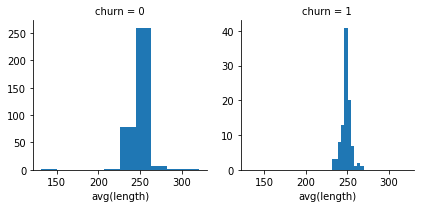

In [21]:
# getting the average length for every user, transform to a Pandas dataframe
length_df = joined_df.groupBy(['userId', 'churn']).avg('length').toPandas()

# visualizing the distribution of length between two groups of users
g = sns.FacetGrid(length_df, col="churn", sharey=False)
g.map(plt.hist, "avg(length)");

In [22]:
# The itemInSession variable, which represents the rank fo the song in the current session
joined_df.groupBy('churn').avg('itemInSession').show(5)

+-----+------------------+
|churn|avg(itemInSession)|
+-----+------------------+
|    1| 107.5093008895664|
|    0|107.82320775209504|
+-----+------------------+



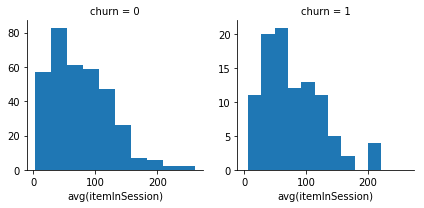

In [23]:
# Visualizing the distribution between both groups
item_df = joined_df.groupBy(['userId','churn']).avg('itemInSession').toPandas()
g = sns.FacetGrid(item_df, col="churn", sharey=False)
g.map(plt.hist, "avg(itemInSession)");

In [24]:
# We can create a variable representing the state
joined_df = joined_df.withColumn('state', substring(col("location"), -2, 3))

# Which are the states where most people decided to churn? 
joined_df.groupBy(['churn', 'state']).count().where(joined_df['churn'] == 0).sort(col('count').desc()).show(5)
joined_df.groupBy(['churn', 'state']).count().where(joined_df['churn'] == 1).sort(col('count').desc()).show(5)

+-----+-----+-----+
|churn|state|count|
+-----+-----+-----+
|    0|   CA|66597|
|    0|   TX|35492|
|    0|   PA|32421|
|    0|   WI|29272|
|    0|   FL|26822|
+-----+-----+-----+
only showing top 5 rows

+-----+-----+-----+
|churn|state|count|
+-----+-----+-----+
|    1|   PA|14638|
|    1|   CA|11574|
|    1|   IN| 8891|
|    1|   TX| 6950|
|    1|   AL| 6258|
+-----+-----+-----+
only showing top 5 rows



In [25]:
# Are there differences based on ts?
joined_df.groupBy('churn').avg('ts').show(5)

+-----+--------------------+
|churn|             avg(ts)|
+-----+--------------------+
|    1| 1.54035761395694E12|
|    0|1.541115986216682...|
+-----+--------------------+



In [26]:
# Let's convert the ts to a date format so we can create several time based features
joined_df = joined_df.withColumn('date', from_unixtime((col('ts')/1000)).cast(DateType()))

In [27]:
# extract day and month from the date column
joined_df = joined_df.withColumn('day', dayofmonth('date')).withColumn('month', month('date'))

# we can now compute for a given user the average number of distinct sessions per day and per month
day_df = joined_df.groupBy(['userId', 'day']).agg(countDistinct('sessionId')).groupBy('userId').avg('count(DISTINCT sessionId)') \
                  .withColumnRenamed('avg(count(DISTINCT sessionId))', 'daily_sessions')
month_df = joined_df.groupBy(['userId', 'month']).agg(countDistinct('sessionId')).groupBy('userId').avg('count(DISTINCT sessionId)') \
                  .withColumnRenamed('avg(count(DISTINCT sessionId))', 'monthly_sessions')

# finally, let's integrate this new information into our dataset for later use 
joined_df = joined_df.join(day_df, on='userId').join(month_df, on='userId')

In [28]:
# Comparing the number of daily and monthly sessions for the two groups of users
joined_df.groupBy('churn').avg('daily_sessions').show()
joined_df.groupBy('churn').avg('monthly_sessions').show()

+-----+-------------------+
|churn|avg(daily_sessions)|
+-----+-------------------+
|    1|  1.574186648920741|
|    0| 1.6177359492828687|
+-----+-------------------+

+-----+---------------------+
|churn|avg(monthly_sessions)|
+-----+---------------------+
|    1|   14.124930050363739|
|    0|   13.961969091198952|
+-----+---------------------+



In [29]:
#Let's do the same process for registration which is also a timestamp that we can convert to dates
joined_df = joined_df.withColumn('registration_date', from_unixtime((col('registration')/1000)).cast(DateType()))
joined_df = joined_df.withColumn('days_since_registration', datediff(current_date(), col('registration_date')))
joined_df = joined_df.withColumn('month_registration', month('registration_date'))

In [30]:
# Are ther differences based on user agent?
joined_df.groupBy(['churn', 'userAgent']).count().where(joined_df['churn'] == 0).sort(col('count').desc()).show(5)
joined_df.groupBy(['churn', 'userAgent']).count().where(joined_df['churn'] == 1).sort(col('count').desc()).show(5)

+-----+--------------------+-----+
|churn|           userAgent|count|
+-----+--------------------+-----+
|    0|"Mozilla/5.0 (Win...|37085|
|    0|"Mozilla/5.0 (Mac...|36479|
|    0|Mozilla/5.0 (Wind...|26025|
|    0|"Mozilla/5.0 (Win...|19743|
|    0|"Mozilla/5.0 (Mac...|19506|
+-----+--------------------+-----+
only showing top 5 rows

+-----+--------------------+-----+
|churn|           userAgent|count|
+-----+--------------------+-----+
|    1|Mozilla/5.0 (Wind...|13431|
|    1|"Mozilla/5.0 (Mac...|12147|
|    1|"Mozilla/5.0 (Win...|11959|
|    1|"Mozilla/5.0 (Mac...| 9603|
|    1|"Mozilla/5.0 (Mac...| 6981|
+-----+--------------------+-----+
only showing top 5 rows



In [31]:
# We can compute the number of downgrades, upgrades, thumbs up, thumbs down, add friend, add to playlist, 
# roll advert events for a given user counting the number of times they occur
for c in ['Downgrade', 'Roll Advert', 'Thumbs Down', 'Add to Playlist', 'Add Friend', 'Thumbs Up']:
    joined_df = joined_df.withColumn(c, (joined_df['Page'] == c).cast(IntegerType()))
    
# We can now create some aggregations and create our ready to use features dataframe
features_df = joined_df.groupBy('userId').agg(avg('itemInSession'),avg('length'),min('daily_sessions'),min('monthly_sessions'),min('days_since_registration'),
                                              min('month_registration'),max('level'),max('userAgent'),max('state'), sum('Downgrade'),sum('Roll Advert'),
                                           sum('Thumbs Down'), sum('Add to Playlist'),sum('Add Friend'), sum('Thumbs Up'), max('churn'))

features_df = features_df.select(col('avg(itemInSession)').alias('itemInSession'),col('avg(length)').alias('length'), col('min(daily_sessions)').alias('daily_sessions'),
                                 col('min(monthly_sessions)').alias('monthly_sessions'),col('min(days_since_registration)').alias('days_since_registration'),
                                 col('min(month_registration)').alias('month_registration'),col('max(level)').alias('level'),col('max(userAgent)').alias('userAgent'),
                  col('max(state)').alias('state'),col('sum(Downgrade)').alias('downgrade'),col('sum(Roll Advert)').alias('rollAdvert'),col('sum(Thumbs Down)').alias('thumbsDown'),
                  col('sum(Add to Playlist)').alias('addToPlaylist'),col('sum(Add Friend)').alias('addFriend'), col('sum(Thumbs Up)').alias('thumbsUp'),col('max(churn)').alias('label'))

In [32]:
# Let's first make sure there are no missing values
features_df.select([count(when(isnull(c), c)).alias(c) for c in features_df.columns]).show()
features_df = features_df.where(col("userAgent").isNotNull()).where(col("state").isNotNull())

+-------------+------+--------------+----------------+-----------------------+------------------+-----+---------+-----+---------+----------+----------+-------------+---------+--------+-----+
|itemInSession|length|daily_sessions|monthly_sessions|days_since_registration|month_registration|level|userAgent|state|downgrade|rollAdvert|thumbsDown|addToPlaylist|addFriend|thumbsUp|label|
+-------------+------+--------------+----------------+-----------------------+------------------+-----+---------+-----+---------+----------+----------+-------------+---------+--------+-----+
|            0|     1|             0|               0|                      1|                 1|    0|        1|    1|        0|         0|         0|            0|        0|       0|    0|
+-------------+------+--------------+----------------+-----------------------+------------------+-----+---------+-----+---------+----------+----------+-------------+---------+--------+-----+



### Selecting Features
>After creating, exploring, transforming and analysing several features between users who decided to churn and those who continue using the service, we are now ready to choose some specific features for training our model:

* We can use the item in session, which loosely translates to the number of songs per session as a predictor for our model
* The state as well as the tier seem to provide information regarding whether a user will churn or not
* After converting the ts column to a date and extracting time-based features such as the average number of sessions per day and per month, we can include that information for our model
* The number of days since registration and the registration month could provide some relevant predicting information.
* Similarly, on-platform behaviors (thumbs up e.g.) can be an indicative mark for churn prediction.

> Said that, the final features to be used are the following:  `'itemInSession'`,`'length'`,`'daily_sessions'`,`'monthly_sessions'`,`'days_since_registration'`,`'month_registration'`,
`'level_index'`,`'state_index'`,`'userAgent_index'`,`'downgrade'`,`'rollAdvert'`,`'thumbsDown'`,`'addToPlaylist'`,
`'addFriend'`,`'thumbsUp'`

<a id='implementation'></a>
## Model Implementation

In [33]:
feature_columns=['itemInSession','length','daily_sessions','monthly_sessions', 'days_since_registration','month_registration','level_index','state_index','userAgent_index','downgrade',\
                 'rollAdvert', 'thumbsDown', 'addToPlaylist','addFriend','thumbsUp']
# We first create a pipeline to prepare our data for modeling
indexer_state = StringIndexer(inputCol='state', outputCol='state_index')
indexer_level = StringIndexer(inputCol='level', outputCol='level_index')
indexer_ua = StringIndexer(inputCol='userAgent', outputCol='userAgent_index')
assembler = VectorAssembler(inputCols=feature_columns,outputCol='features')
features_pipeline = Pipeline(stages=[indexer_state, indexer_level, indexer_ua, assembler])

model_df = features_pipeline.fit(features_df).transform(features_df)

In [34]:
# Due to the structure of data, we need to convert some features vector from Sparse to Dense
df2 = model_df.select("label", "features")
rdd = df2.rdd.map(lambda x: Row(label=x[0],features=DenseVector(x[1].toArray()))
                     if (len(x)>1 and hasattr(x[1], "toArray"))
                     else Row(label=None, features=DenseVector([])))
model_data = spark.createDataFrame(rdd)

In [35]:
# Create a function to train and evaluate a model
def train_model(train, test, model):
    '''
    INPUTS:
    train: a Spark data frame with the training data
    test : a Spark data frame with testing data
    model(string): the name of one of the available models to train, only the options: 'logistic_regression', 'random_forest' 
                    or 'gradient_boosting' are available.
    
    OUTPUT:
    This fucntion does not return anything, but prints out the accuracy and f1 score for the selected model
    
    DESCRIPTION:
    This function fits and evaluates the performance of three different classification models 
    running on their default parameters. It helps identifying the model that best performs on the given
    data and so the best candidate for hyper-parameters tuning. 
    '''
    # Choose the model
    if model == 'logistic_regression':
        ml = LogisticRegression()
    elif model == 'random_forest': 
        ml = RandomForestClassifier()
    elif model == 'gradient_boosting':
        ml = GBTClassifier()
    else:
        return "Please choose one model between:'logistic_regression','random_forest' and 'gradient_boosting'"
    
    # Fit and calculate predictions
    classification = ml.fit(train)
    results = classification.transform(test)
    
    # Calculate accuracy and F-1 score
    accuracy_evaluator = MulticlassClassificationEvaluator(metricName='accuracy')
    accuracy = accuracy_evaluator.evaluate(results.select(col('label'), col('prediction')))
    
    f1_score_evaluator = MulticlassClassificationEvaluator(metricName='f1')
    f1_score = f1_score_evaluator.evaluate(results.select(col('label'), col('prediction')))
    
    print('For {}, the accuracy on the test set is {:.2%} and the F-1 score is {}'\
    .format(model, accuracy, f1_score))

In [36]:
# Split this data between train, validation and test sets
train, test = model_data.randomSplit([0.8, 0.2], seed=42)

# Due to the class imbalance, we upsample the categories who churned in the training dataset
print('In our training set, before upsampling we have {} users who churned and {} who did not.'.format(train.where(col('label') == 1).count(),
                                                                                           train.where(col('label') == 0).count()))

train_churn = train.where(col('label') == 1).sample(True, train.where(col('label') == 0).count()/train.where(col('label') == 1).count())
train_no_churn = train.where(col('label') == 0)
train = train_churn.unionAll(train_no_churn)


In our training set, before upsampling we have 79 users who churned and 283 who did not.


In [37]:
# Fit selected models and visualize their performance
for model in ['logistic_regression', 'random_forest', 'gradient_boosting']:
    train_model(train, test, model)

For logistic_regression, the accuracy on the test set is 60.47% and the F-1 score is 0.6352436323366557
For random_forest, the accuracy on the test set is 67.44% and the F-1 score is 0.6841305496828751
For gradient_boosting, the accuracy on the test set is 76.74% and the F-1 score is 0.7711900502598177


<a id='evaluation'></a>
## Evaluating Model Performance
>There are quite important performance differences for the three selected models. The gradient_boosting classifier did it pretty well reaching the highest accuracy and f1 scores running on the default parameters, then followed by the random_forest and the worst was the logistic-regression. 
> Let's find out if we can achieve even better results by optimizing the Gradient Boosting and the Random Forest models. 

In [ ]:
#Optimize a GradientBoosting model through Grid Search
##########################################################
gbt = GBTClassifier()

paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())

gbt_crossval = CrossValidator(estimator=gbt,#Pipeline(stages=[gbt]),
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

###############################################################
gbt_classifier = crossval.fit(train)
predictions = gbt_classifier.transform(test)

# Calculate accuracy and F-1 score
acc_eval = MulticlassClassificationEvaluator(metricName='accuracy')
accuracy = acc_eval.evaluate(results.select(col('label'), col('prediction')))

f1_score_evaluator = MulticlassClassificationEvaluator(metricName='f1')
f1_score = f1_score_evaluator.evaluate(results.select(col('label'), col('prediction')))

print('For the {} classifier, the accuracy on the test set is {:.3%} and the F-1 score is {}'\
.format(gbt, accuracy, f1_score))

### Note: 
>Even though the Gradient Boosting Classifier had the best performance making predictions on the test data, since it took so long to optimize a model using GridSearch and I was running out of credits on Watson Studio, I decided to continue with the optimization of a Random Forest model which is remarkably faster to train, thus consuming less processing unit hours.

In [42]:
#Optimize a Random Forest model through Grid Search
model = RandomForestClassifier()
#Defining Grid Parameters
param_grid = ParamGridBuilder()\
            .addGrid(model.numTrees, [5, 10, 20, 50])\
            .addGrid(model.maxDepth, [5, 10])\
            .addGrid(model.impurity, ["entropy", "gini"])\
            .build()

crossval = CrossValidator(estimator = Pipeline(stages=[model]),
                         estimatorParamMaps = param_grid,
                         evaluator = MulticlassClassificationEvaluator(),
                         numFolds = 3)

# Running cross-validation on the training set, and choose the best set of parameters.
cvModel = crossval.fit(train)
# Making predictions on test set. cvModel uses the best model found.
predictions = cvModel.transform(test)

# Calculate accuracy and F-1 score
acc_eval = MulticlassClassificationEvaluator(metricName='accuracy')
accuracy = acc_eval.evaluate(predictions.select(col('label'), col('prediction')))

f1_score_eval = MulticlassClassificationEvaluator(metricName='f1')
f1_score = f1_score_eval.evaluate(predictions.select(col('label'), col('prediction')))

print('For {}, the accuracy on the test set is {:.2%} and the F-1 score is {}'\
.format(model, accuracy, f1_score))

For RandomForestClassifier_476ba9b64c1952b2969e, the accuracy on the test set is 75.58% and the F-1 score is 0.7188945777558449


In [44]:
# Examine feature importance
DenseVector(cvModel.bestModel.stages[-1].featureImportances)

DenseVector([0.0982, 0.0665, 0.0306, 0.0705, 0.1014, 0.0222, 0.0093, 0.0584, 0.0715, 0.0681, 0.0874, 0.0789, 0.0621, 0.0752, 0.0999])

In [45]:
# Examine feature importance
cvModel.bestModel.stages[0].featureImportances

SparseVector(15, {0: 0.0982, 1: 0.0665, 2: 0.0306, 3: 0.0705, 4: 0.1014, 5: 0.0222, 6: 0.0093, 7: 0.0584, 8: 0.0715, 9: 0.0681, 10: 0.0874, 11: 0.0789, 12: 0.0621, 13: 0.0752, 14: 0.0999})

In [46]:
feature_columns=['itemInSession','length','daily_sessions','monthly_sessions', 'days_since_registration','month_registration','level_index','state_index','userAgent_index','downgrade',\
                 'rollAdvert', 'thumbsDown', 'addToPlaylist','addFriend','thumbsUp']

In [47]:
#Checking features importance
rf_feature_importance_df = pd.DataFrame()
rf_feature_importance_df['feature'] = feature_columns
rf_feature_importance_df['importance'] = cvModel.bestModel.stages[0].featureImportances.values.tolist()
rf_feature_importance_df = rf_feature_importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)
rf_feature_importance_df

,feature,importance
0,days_since_registration,0.101393
1,thumbsUp,0.099933
2,itemInSession,0.098195
3,rollAdvert,0.087403
4,thumbsDown,0.078860
5,addFriend,0.075230
6,userAgent_index,0.071500
7,monthly_sessions,0.070452
8,downgrade,0.068074
9,length,0.066487


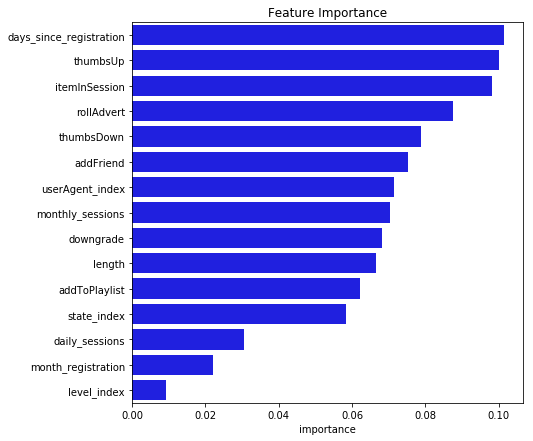

In [48]:
#Let's create a visualization of the feature importance for predicting churn
plt.figure(figsize=(7,7))
sns.barplot(x='importance', y='feature', data=rf_feature_importance_df, color="b")
plt.title('Feature Importance')
plt.ylabel('');

<a id='results'></a>
# Analysis & Results

>Starting from loading the dataset into the IBM Cloud, then doing some data wrangling and exploratory
data analysis, we performed a features engineering process, considering those features related to the
account characterestics, like for instance whether the account was paid vs. free, state, and registration date.
Additionally, user's behavior when interacting on the platform (thumbs up, creation of playlists, number of songs per session etc.) was considered as potential churn predictors. All those features were used to engineer a final
dataset, then applied some transformations so that it could be used to efficiently process the data to train 
a machine learning classifier using the Spark MLlib. 

>Before creating the final model, I tested three different classifiers, namely `LogisticRegression`, `RandomForestClassifier`,`GBTClassifier` and compared their accuracy and F1 score on the test set. Based on the
results, it was clear that the GBTClassifier outperformed the other two models, so I tried to optimize a GBTClassifier using a `CrossValidator` and `GridSearch` but it took so long to train that I decided to continue tuning a RandomForest model which was faster to optimize and also allows performing a features importance analysis.  

>After hyperparameter tuning, the evaluation of the final model showed a 75.58% accuracy on the test set,
with a F1 score of 0.72. There was a significant performance improvement after applying GridSearch as compared to the
model running on the default parameters, but still not as good as the GBTClassier. 

>Looking at feature importance, we see that `days_since_registration`,`thumbs_up` and `itemsInSession` are the most important predictors of churn. So, the time a given user has been interacting with the platform and the behavior during those interactions are relevant features that let us flag a risk of churn. Getting this insight is crucial for Sparkify, since allows targeting those users representing a high risk of churn with special offers that keep them connected to the application. 

<a id='discussion'></a>
## Discussion & Possible Improvements

>By using a larger dataset and exploiting the full potential of cloud deployment, we could further improve this analysis and build an even better classifier(possible by optimizing a GBTClassifier). Grid search has shown to be a particularly computationally expensive operation, but with better resources and more time, there is plenty of room for improvement. Despite that fact, this notebook is a very useful guideline on how to use Spark on IBM Watson Studio to run big data analysis and build machine learning classifier on the cloud.   

>As more users get into the platform, we can regularly run the model to see if there are significant changes on their behavior and thus use that knowledge to further improve our model.

>We can design experiments to identify and evaluate risk mitigation actions that help reducing churn. An idea would be to run A/B tests to evaluate the effectiveness of some particular mitigating actions taken. A way to implement such an experiment would be to find users identified at high risk of churn, split them into a control and treatment group, assign some "churn-mitigating" treatment and compare their churn rates through statistical hypothesis testing. This is only an idea that could be a good complement this analysis. 

<a id='conclusion'></a>
## Conclusion

>By using historical log data and using Spark on the IBM Cloud platform, specifically Watson Studio, we could build a Random Forest classifier able to predict churn for Sparkify's users with close to 76% accuracy on the test set, and a F1 score of around 0.72 ensures we have a good balance between precision and recall.

>Sparkify can use the insights from this analysis for better business decision making and take actions to mitigate the risk of churn and that way improving revenue, growth and good health of the business. 

>Additional measures like A/B testing can complement the analysis and help figuring out the most effective ways of reducing churn. 

>I recommend replicating this analysis on a larger dataset and using the full potential of Spark and the IBM Cloud cluster to improve the performance of our model through GridSearch testing on different classifiers with a more extensive combination of hyper-parameters tuning.   

<a id='reference'></a>
# References

* [Udacity Data Science ND: SparkCourse](https://classroom.udacity.com/nanodegrees/nd025/parts/3e1c3447-39e1-476e-a5f3-8822fa52f9a3/modules/78172901-c80c-4d14-9640-bf10d509f0b9/lessons/ddbf749e-6536-4081-bf9f-9c20e59aee8c/concepts/373ea389-9540-42dc-916d-fcaa63359d53)
* [SparkMLlib Documentation](https://spark.apache.org/docs/latest/ml-tuning.html)
* [Random Forest Classifier with Apache Spark](https://medium.com/rahasak/random-forest-classifier-with-apache-spark-c63b4a23a7cc)
* [The internals of Spark SQL](https://jaceklaskowski.gitbooks.io/mastering-spark-sql/spark-sql.html)
* [Tuning Random Forest algorithm](https://grzegorzgajda.gitbooks.io/spark-examples/content/classification/rf-tuning.html)
* [RANDOM FOREST WITH PYTHON AND SPARK ML](https://www.silect.is/blog/2019/4/2/random-forest-in-spark-ml)
* [Learning Apache Spark with Python](https://runawayhorse001.github.io/LearningApacheSpark/classification.html#gradient-boosted-tree-classification)
* [Spark SQL Tutorial](https://www.tutorialspoint.com/spark_sql/)
* [Machine Learning with PySpark and MLlib](https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa)